In [32]:
import numpy as np
import cv2
from skimage import color, feature, io
from skimage.morphology import square, binary_closing
from skimage.measure import moments_hu
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from os import listdir
from os.path import isfile, join
from skimage import img_as_ubyte

# Shape features: Hu Moments
def get_shape_features(image):
    image_gray = color.rgb2gray(image)
    binary_image = binary_closing(image_gray > 0.5, square(3))  # Apply threshold and morphological closing
    moments = moments_hu(binary_image)  # Extract Hu Moments
    return moments

# Texture features: Local Binary Patterns (LBP)
def get_texture_features(image):
    image_gray = color.rgb2gray(image)
    image_gray_ubyte = img_as_ubyte(image_gray)  # Convert to 8-bit integer format
    lbp = feature.local_binary_pattern(image_gray_ubyte, P=8, R=1, method="uniform")  # LBP with 8 points and radius 1
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8+3), range=(0, 8+2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram
    return hist

# Color features: HSV Color Histogram
def get_color_histogram(image):
    hsv_image = color.rgb2hsv(image)
    hist_h = np.histogram(hsv_image[:, :, 0], bins=10, range=(0, 1))[0]  # Hue channel
    hist_s = np.histogram(hsv_image[:, :, 1], bins=10, range=(0, 1))[0]  # Saturation channel
    hist_v = np.histogram(hsv_image[:, :, 2], bins=10, range=(0, 1))[0]  # Value channel
    hist = np.concatenate([hist_h, hist_s, hist_v])
    hist = hist / hist.sum()  # Normalize the histogram
    return hist

# Defining dataset path and categories
data_path = "C:\\Users\\harsh\\Downloads\\data_science_project"
categories = ['Lemon', 'Mango', 'Jamun', 'Unidentified']
features = []
labels = []

for label, category in enumerate(categories):
    category_path = join(data_path, category)
    images = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    
    for img_name in images:
        image_path = join(category_path, img_name)
        image = io.imread(image_path)
        image_resized = cv2.resize(image, (148, 224))  # Resize

        # Extracting features
        shape_features = get_shape_features(image_resized)
        texture_features = get_texture_features(image_resized)
        color_features = get_color_histogram(image_resized)
        
        # Combine all features into a single array
        combined_features = np.hstack([shape_features, texture_features, color_features])
        features.append(combined_features)
        labels.append(label)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(train_x, train_y)

# Make predictions on the test set
predictions = rf_model.predict(test_x)

# Calculate accuracy
accuracy = accuracy_score(test_y, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(test_y, predictions, target_names=categories))



Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

       Lemon       1.00      1.00      1.00        33
       Mango       0.97      0.94      0.95        31
       Jamun       0.96      0.96      0.96        27
Unidentified       0.88      0.91      0.89        23

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Predicted Category: Unidentified


In [ ]:
# Print feature importance

importances = rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

print("Feature importances:")
for i in sorted_indices[:10]:  # Top 10 features
    print(f"Feature {i}, Importance: {importances[i]:.4f}")

In [ ]:
# Prediction for a new image

def predict_leaf_category(image_path):
    new_leaf_image = io.imread(image_path)
    new_leaf_resized = cv2.resize(new_leaf_image, (148, 224))
    
    # Extract features from the new leaf image
    new_shape_features = get_shape_features(new_leaf_resized)
    new_texture_features = get_texture_features(new_leaf_resized)
    new_color_features = get_color_histogram(new_leaf_resized)
    
    # Combine all features into a single array
    new_combined_features = np.hstack([new_shape_features, new_texture_features, new_color_features])
    
    # Predict the category (Lemon, Mango, Jamun, or Unidentified)
    prediction = rf_model.predict([new_combined_features])
    print(f"Predicted Category: {categories[prediction[0]]}")

# Example usage:
# Predict a new leaf image (replace with actual file path)
predict_leaf_category("C:\\Users\\harsh\\Downloads\\0007_0324.JPG")


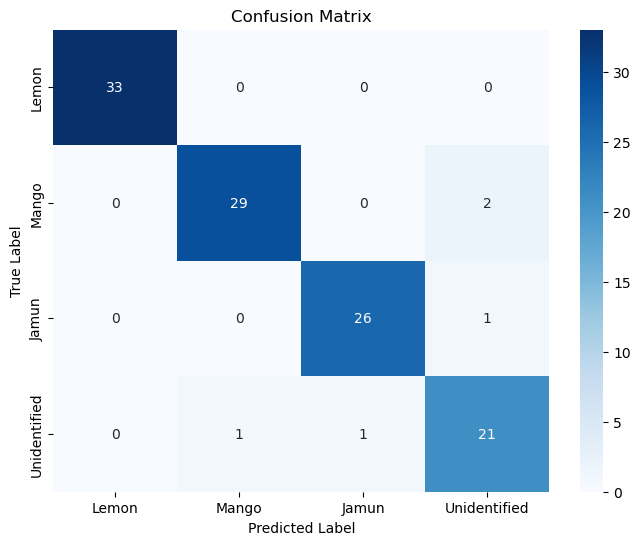

In [33]:
# Generate the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()